In [1]:
import scipy as sc
from scipy import optimize as op
import math as m
import matplotlib as mp
from matplotlib import pyplot as pl
import datetime as d
import numpy as np
from numpy import random as r
import os
import string
import sys
#import ok
def test_func(x, a, b, c, d): #This is the sine function used for data fitting
    return ((a * np.sin((b * x)+c)+d))

ImportError: dlopen(/Users/walterwilson/Chronopixel_Data_Analysis/_ok.so, 2): Library not loaded: /usr/local/opt/python/Frameworks/Python.framework/Versions/3.6/Python
  Referenced from: /Users/walterwilson/Chronopixel_Data_Analysis/_ok.so
  Reason: image not found

In [3]:
#IMPORTANT: The following four functions perform all of the tasks which were shown above such as reading in the data
# and creating the saved compressed file
#This first function will read in the data, put it in the correct format and save the file
#The required input is the data array from the signal
print(sys.version);
def save(data, start=d.datetime.utcnow(), t_stamp=4095,pixel=400, thres_volt="10 mV", comment='Fill with any comments',temp='ex',
freq='50MHz'):
    filename= 'chronopixel_hits_%s.npz' %start; #Creating the name for the first file with a date label
    metadata=np.chararray((6,2), unicode=True, itemsize=60); #Creating an array for the metadata and storing each 
    metadata[0][0]='filename'; #Required value
    metadata[0][1]=filename;
    metadata[1][1]=run_start;
    metadata[2][0]="Threshold Voltage";
    metadata[2][1]=thres_volt;
    metadata[3][0]="Temperature";
    metadata[3][1]=temp;
    metadata[4][0]="Clock Frequency";
    metadata[4][1]=freq;
    metadata[5][0]="Run Comments";
    metadata[5][1]=comment;
    runs=int(len(data)/(pixel*t_stamp)); #Determining the number of readouts
    data_array= np.empty([t_stamp, pixel, runs]); #Creating an array to hold the signal data
    #The data is in a 3 dimensional array and has the timestamp on the x-axis, 
    #the pixel number on the y-axis and the readout number on the z-axis
    for n in range(runs):
        for m in range((n*t_stamp),((n+1)*t_stamp)):
            for i in range(pixel):
                data_array[(m-(n*t_stamp))][i][n]=data[m+n+i];
    time=np.empty([runs,t_stamp]); 
    for n in range(runs):
        for m in range(t_stamp):
            time[n][m]=(n*t_stamp)+m 
    hits=np.empty([runs,len(data_array[:,0,0])]); 
    for n in range(runs): 
        for m in range(len(data_array[:,0,0])):
            hits[n][m]=sum(data_array[m,:,n]);
    print(hits);
    path=u'/Users/walterwilson/Chronopixel_Data_Analysis/%s'%filename; #Adding the directory to the file
    file= np.savez_compressed(filename, data=hits, time=time, meta=metadata); #Saving the file
    return(start, runs, path) #Returning the start time, number of runs and the file name

3.6.0 |Anaconda custom (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [4]:
#This function plots the different readout. The required inputs are the save file name 
#and the number of readouts in the data collection
def hits_plot(path, runs, begin=0, end=-1):
    opened_file=np.load(path);
    for n in range(runs): #Plotting the number of recorded hits at each timestamp for each of the readouts
        y=opened_file['data'][n,begin:end];
        time=opened_file['time'];
        params, params_covariance = op.curve_fit(test_func, time[n,begin:end], y, method='lm'); #Adding a sine fit to the data 
        pl.plot(time[n,begin:end], y);
        pl.plot(time[n,begin:end], test_func(time[n,begin:end], params[0], params[1], params[2], params[3]));
        pl.show();
        print(params);

4914000
3
[[ 194.  195.  196. ...,  223.  222.  223.]
 [ 223.  223.  223. ...,  206.  206.  206.]
 [ 204.  203.  204. ...,  209.  209.  209.]]


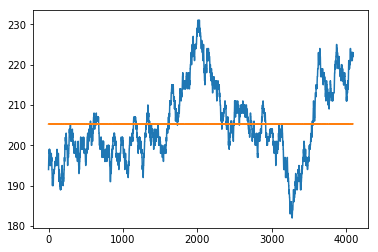

[ -2.55817932e-02   1.00003984e+00   8.36169947e-01   2.05275779e+02]


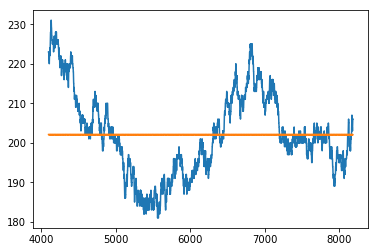

[ -4.00612714e-02   1.00035523e+00  -2.01615028e+00   2.02072544e+02]


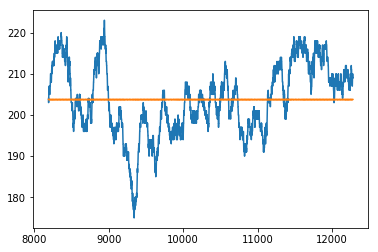

[ -2.87893125e-02   9.99345572e-01   7.94048075e+00   2.03740592e+02]


In [5]:
#Testing the functions with random data to see if there are any problems
data=r.randint(2, size=(4914000));
print(len(data));
run_start = d.datetime.utcnow(); 
start,runs,path=save(data, run_start);
hits_plot(path, runs);

In [13]:
#This file combines all of the readouts into one continuous timestream and saves it as a new file
def combine_runs(path, runs, start, t_stamp=4095,pixel=400,):
    opened_file=np.load(path); #Opening the first file
    com_data=np.empty([runs*t_stamp]); #Creating an array for the combined data
    data=opened_file['data'] #Putting the signal data from the first file in an array
    #This loop puts the signal data into a one-dimensional array, combining the different readouts in order
    for m in range(runs):
        for n in range(4095):
            com_data[n+(m*t_stamp)]=data[m][n];
    time=np.empty([runs*t_stamp]);
    for n in range(runs*t_stamp): #This combines the timestamps
        time[n]=n;
    name='total_hits_%s.npz' %start; 
    new_path= u'/Users/walterwilson/Chronopixel_Data_Analysis/%s'%name; #Creating and saving the 2nd file
    file= np.savez_compressed(name, data=com_data, time=time, meta=opened_file['meta']);
    return(new_path)

In [14]:
#Plots a single graph for the entire data collection
def com_plot(path, begin=0, end=-1):
    opened_file=np.load(path);
    y=opened_file['data'][begin:end];
    time=opened_file['time'];
    #Adding a sine fit to the data
    params, params_covariance = op.curve_fit(test_func, time[begin:end], y, method='lm'); 
    pl.plot(time[begin:end], y);
    pl.plot(time[begin:end], test_func(time[begin:end], params[0], params[1], params[2], params[3]));
    pl.show();
    print(params);

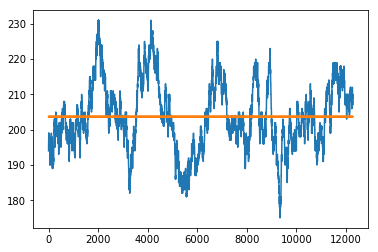

[ -2.57681299e-02   1.00001945e+00   6.30926186e-01   2.03698063e+02]


In [15]:
#Testing the functions
com_path = combine_runs(path, runs, run_start);
com_file=np.load(com_path);
com_plot(com_path);

In [9]:
avr_hits=np.empty(len(hits[:,0])) #Finding the average number of detected hits for each readout
for n in range(len(hits[:,0])):
    avr_hits[n]=sum(hits[n,:])/len(hits[n,:])
print(avr_hits);

NameError: name 'hits' is not defined